In [1]:
import pandas as pd
# import talib
import numpy as np
from numpy.linalg import eig
import math
# from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from matplotlib import pyplot as plt
import datetime
import torch
from torch import nn
from d2l import torch as d2l
import talib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./data//future_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()


,date,open,close,high,low,volume,open_interest
0,2010-01-04 09:01:00,3050.0,3044.0,3052.0,3037.0,24504.0,1037876.0
1,2010-01-04 09:02:00,3044.0,3043.0,3044.0,3040.0,13112.0,1039112.0
2,2010-01-04 09:03:00,3043.0,3047.0,3048.0,3042.0,14848.0,1038992.0
3,2010-01-04 09:04:00,3047.0,3045.0,3049.0,3045.0,13966.0,1039932.0
4,2010-01-04 09:05:00,3045.0,3034.0,3045.0,3033.0,13958.0,1039250.0


In [3]:
data.tail()

,date,open,close,high,low,volume,open_interest
810145,2020-12-31 14:56:00,3479.0,3475.0,3479.0,3475.0,7084.0,1666040.0
810146,2020-12-31 14:57:00,3476.0,3475.0,3476.0,3473.0,6747.0,1665150.0
810147,2020-12-31 14:58:00,3474.0,3473.0,3474.0,3472.0,11273.0,1664198.0
810148,2020-12-31 14:59:00,3473.0,3476.0,3477.0,3472.0,9232.0,1661309.0
810149,2020-12-31 15:00:00,3476.0,3479.0,3480.0,3476.0,20908.0,1656231.0


In [4]:
def transfrom_data(data,peroid,p_peroid,yuezhi,if_test = False):
    # 处理数据格式
    p_data = data[['date','close','high','low','volume','open_interest']].reset_index(drop = True)
    p_data['d_high'] = p_data['high']
    p_data['d_close'] = p_data['close']
    p_data['d_low'] = p_data['low']
    p_data['d_insterest'] = p_data['open_interest']
    p_data['Y'] = p_data['close']
    
    p_data['d_high'][1:p_data.shape[0] - peroid] = p_data['high'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_low'][1:p_data.shape[0] - peroid] = p_data['d_low'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_close'][1:p_data.shape[0] - peroid] = p_data['d_close'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_insterest'][1:p_data.shape[0] - peroid] = p_data['d_insterest'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['open_interest'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)

    #     p_data['Y'][1:p_data.shape[0] - peroid] = (p_data['close'][1 + p_peroid:p_data.shape[0] - peroid + p_peroid].reset_index(drop = True) - p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)) / p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)
    p_data['Y'][1:p_data.shape[0] - peroid] = p_data['close'][1 + p_peroid:p_data.shape[0] - peroid + p_peroid].reset_index(drop = True) - p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)
    
    o_data = p_data.iloc[1:p_data.shape[0] - peroid,[0,4,6,7,8,9,10]].reset_index(drop = True)
    
    X = o_data.values[:,1:-1]
    Time = o_data.values[:,0]
    Y = o_data.values[:,-1]
    data_x = np.zeros((X.shape[0],X.shape[1] * peroid))
    
    # 转换时间周期
    for i in range(peroid):    
        data_x[peroid:,i * 5 : i * 5 + 5] = X[peroid - i:X.shape[0]-i,:]
    data_X = data_x[peroid:,:]
    data_Time = Time[peroid:]
    data_Y = Y[peroid:]
    
    # 时间筛选
    data_Time = pd.DataFrame(data_Time)
    d_list = list(data_Time[data_Time[0].str.contains(' 09:')].index.values) + list(data_Time[data_Time[0].str.contains(' 21:')].index.values)
    d_list.sort()
    time_list = []
    k = 0
    for i in range(data_Time.shape[0]):
        if k == len(d_list) or i != d_list[k]:
            time_list.append(i)
        else:
            k += 1
            
    data_X = pd.DataFrame(data_X).iloc[time_list,:]
    data_X = data_X.reset_index(drop = True)
    data_Y = pd.DataFrame(data_Y).iloc[time_list,:]
    data_Y = data_Y.reset_index(drop = True)
    data_Time = pd.DataFrame(data_Time).iloc[time_list,:].reset_index(drop = True)

#     data_list0 = list(data_Y[abs(data_Y[0]) <= yuezhi].index.values)
    if if_test == False:
        data_list1 = list(data_Y[data_Y[0] > yuezhi].index.values)
        data_list2 = list(data_Y[data_Y[0] < -yuezhi].index.values)
        data_list = data_list1 + data_list2
        data_list.sort()

        data_X = data_X.iloc[data_list,:].reset_index(drop = True)
        data_Y = data_Y.iloc[data_list,:].reset_index(drop = True)
        data_Time = data_Time.iloc[data_list,:].reset_index(drop = True)
        data_Y[data_Y[0] > yuezhi] = 1
        data_Y[data_Y[0] < -yuezhi] = 0
        split = len(data_X) // 10

    if if_test == True:
        split = len(data_X) // 10
        t_list = list(range(len(data_Y)-split,len(data_Y)))
        t_Y = data_Y.iloc[t_list,:].reset_index(drop = True)
             
        data_Y[(data_Y[0]) <= yuezhi] = 0
        data_Y[data_Y[0] != 0] = 1     
        
    mean = data_X.mean()
    std = data_X.std()
    data_X = preprocessing.scale(data_X)
    data_X = pd.DataFrame(data_X)
    
    return [data_X,data_Y,data_Time,t_Y,mean,std,split]


In [5]:
peroid = 30
p_peroid = 5
yuezhi = 4
d_X,d_Y,d_T,t_y,mean,std,split = transfrom_data(data,peroid,p_peroid,yuezhi,if_test = True)

In [6]:
def split_data(d_X,d_Y,d_T,split,if_des = True):
    test_x = d_X.iloc[-split:,:]
    test_y = d_Y.iloc[-split:,:]
    test_T = d_T.iloc[-split:,:]
    
    X_test = torch.tensor(test_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_test = torch.tensor(np.array(test_y,dtype = float))[:,0].to(torch.long)
    
    tv_x = d_X.iloc[:-split,:]
    tv_y = d_Y.iloc[:-split,:]
    
    # 降采样
    if if_des:
        waste,use = train_test_split(list(tv_y[tv_y[0] == 0].index), test_size=0.06)

        use += list(tv_y[tv_y[0] == 1].index) 
        use.sort()

        tv_x = tv_x.iloc[use,:]
        tv_y = tv_y.iloc[use,:]
    
    train_x, valid_x, train_y, valid_y = train_test_split(tv_x,tv_y, test_size=0.2)
    
    X_train = torch.tensor(train_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_train = torch.tensor(np.array(train_y,dtype = float))[:,0].to(torch.long)
    
    X_valid = torch.tensor(valid_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_valid = torch.tensor(np.array(valid_y,dtype = float))[:,0].to(torch.long)
    
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test,test_T
    
    

In [7]:
X_train,Y_train,X_valid,Y_valid,X_test,Y_test,test_T = split_data(d_X,d_Y,d_T,split,if_des = True)

In [8]:
X_train.shape,Y_train.shape

(torch.Size([47638, 30, 5]), torch.Size([47638]))

In [9]:
d_Y[d_Y[0] == 0].index.shape[0],d_Y[d_Y[0] == 1].index.shape[0],d_Y[d_Y[0] == -1].index.shape[0]

(538089, 33848, 0)

In [10]:
len(Y_test[Y_test == 0]),len(Y_test[Y_test == 1]),len(Y_test[Y_test == -1])

(53837, 3356, 0)

In [11]:
len(Y_train[Y_train == 0]),len(Y_train[Y_train == 1]),

(23297, 24341)

In [12]:
len(test_T),len(t_y)

(57193, 57193)

In [13]:
t_y

,0
0,1.0
1,4.0
2,2.0
3,0.0
4,1.0
...,...
57188,1.0
57189,5.0
57190,2.0
57191,1.0


In [14]:
import random
import torch.backends.cudnn as cudnn


def set_seed(seed=41):
    """
    torch.backends.cudnn.enabled =True，说明设置为使用非确定性算法
    torch.backends.cudnn.benchmark=True.将会让程序在开始时花费一点额外时间，
    为整个网络的每个卷积层搜索最适合它的卷积实现算法，进而实现网络的加速。
    :param seed: int
    :return:

    """
    print(f'Random Seed: {seed}\n')
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    # cudnn.enabled = True
    # cudnn.benchmark = True

class LSTM_Model(nn.Module):
    """
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1,batch_first = True,dropout = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first = batch_first,dropout = dropout)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, _x):
        x, _ = self.lstm(_x)  
        out = self.out(x[:, -1, :])
        return out



In [15]:
def accuracy(y_hat, y):  
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [16]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [17]:
def train_epoch(net, train_iter, loss, updater): 
    
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
    #     print(y_hat,Y[:,0])
    #     break

        l = loss(y_hat,y)

        updater.zero_grad()
        l.mean().backward()
        updater.step()
        
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [18]:
def train(net, train_iter, valid_iter,test_iter, loss, num_epochs, updater,if_save = False):  #@save
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'valid acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        
        valid_acc = evaluate_accuracy(net, valid_iter)
        test_acc = evaluate_accuracy(net, test_iter)
        
        animator.add(epoch + 1, train_metrics + (valid_acc,)+ (test_acc,))
        if if_save:
            if test_acc > 0.45:
                return test_acc
        
    train_loss, train_acc = train_metrics
    return test_acc
    

In [19]:
from torch.utils import data 

def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 500

train_iter = load_array((X_train, Y_train), batch_size)
valid_iter = load_array((X_valid, Y_valid), batch_size)
test_iter = load_array((X_test, Y_test), batch_size)

In [26]:
hidden_size = 8
out_size = 2 
num_layers = 3
dropout = 0.6

set_seed(88)

net = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.001)
# updater = torch.optim.SGD(net.parameters(), lr=0.01)

Random Seed: 88



0.6231007291102058

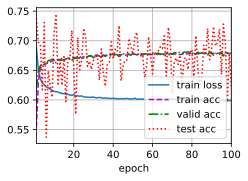

In [27]:
num_epochs = 100

train(net, train_iter, valid_iter,test_iter,loss, num_epochs, updater,if_save=False)

0.6992813805885335

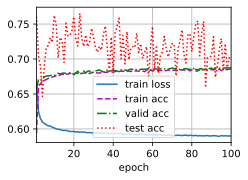

In [49]:
num_epochs = 100

train(net, train_iter, valid_iter,test_iter,loss, num_epochs, updater,if_save=False)

In [18]:
hidden_size_list = [6,8,10,12,14,16,18,20]
num_layers_list = [1,2,3,4,5,6]
dropout_list = [0,0.3,0.5,0.6]

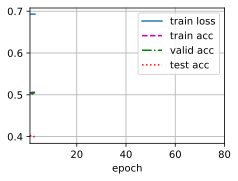

In [ ]:
# num_net = 0
# param_list = []
# for hidden_size in hidden_size_list:
#     for num_layers in num_layers_list:
#         for dropout in dropout_list:
#             out_size = 2 

#             set_seed(num_net)

#             net = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

#             loss = nn.CrossEntropyLoss(reduction='none')
# # loss = cross_entropy
# # loss =nn.MSELoss()
#             updater = torch.optim.Adam(net.parameters(), lr=0.001)
#             num_epochs = 80
#             test_acc = train(net, train_iter, valid_iter,test_iter,loss, num_epochs, updater,if_save=True)
#             if test_acc > 0.43:
#                 torch.save(net.state_dict(),f'lstm_2.params_{num_net}')
#                 num_net += 1
#                 param_list.append([hidden_size,num_layers,dropout])
#                 print([hidden_size,num_layers,dropout])
# # updater = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
print(param_list)

In [ ]:
num_epochs = 30

train(net, train_iter, valid_iter,test_iter,loss, num_epochs, updater,if_save=True)

In [23]:
evaluate_accuracy(net,test_iter)
net.eval()
y_hat = net(X_test)
y_hat = y_hat.argmax(axis=1)
cmp = y_hat.type(Y_test.dtype) == Y_test
float(cmp.type(Y_test.dtype).sum())/len(y_hat)


0.7707586592764849

In [28]:
net.eval()
y_hat = net(X_test)
y_hat

tensor([[ 0.4958, -0.5366],
        [ 0.3934, -0.4566],
        [ 0.5597, -0.5931],
        ...,
        [-0.1996, -0.0227],
        [-0.2429,  0.0337],
        [-0.2135, -0.0050]], grad_fn=<AddmmBackward0>)

In [29]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

In [30]:
y_hat = softmax(y_hat)

In [31]:
y_hat

tensor([[0.7374, 0.2626],
        [0.7006, 0.2994],
        [0.7600, 0.2400],
        ...,
        [0.4559, 0.5441],
        [0.4313, 0.5687],
        [0.4481, 0.5519]], grad_fn=<DivBackward0>)

In [40]:

def f_score(y_pre,y_test,split0,split1,split2 = 0):
    '''
    分类准确率划分
    '''
    sum0 = 0
    count0 = 0
    sum1 = 0
    count1 = 0
    sum2 = 0
    count2 = 0
    ind1 = []
    
    for i in range(len(y_pre)):
        if y_pre[i,0] >= split0:
            sum0 += 1
            if y_test[i] == 0:
                count0 += 1
        if y_pre[i,1] >= split1:
            sum1 += 1
            ind1.append(i)
            if y_test[i] == 1:
                count1 += 1
        if split2 > 0.1:
            if y_pre[i,2] >= split2:
                sum2 += 1
                if y_test[i] == 2:
                    count2 += 1
    sum0 = 1 if sum0 == 0 else sum0
    sum1 = 1 if sum1 == 0 else sum1
    sum2 = 1 if sum2 == 0 else sum2
    if split2 > 0.1:
        return count0 / sum0,sum0,count0,count1 / sum1,sum1,count1,count2 / sum2,sum2,count2
    
    return count0 / sum0,sum0,count0,count1 / sum1,sum1,count1,ind1


In [49]:
a,b,c,d,e,f,ind1 = f_score(y_hat,Y_test,0.5,0.8)
re = t_y.values[ind1,:].sum(axis = 0)
(re * 10 - len(ind1) * 3) / len(ind1),len(ind1)

(array([10.922413793103448], dtype=object), 696)

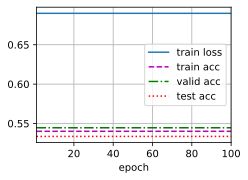

In [24]:
hidden_size = 28
out_size = 2 
num_layers = 1
dropout = 0

num_epochs = 100
net1 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.01)
train(net1, train_iter, valid_iter,test_iter,loss, num_epochs, updater)

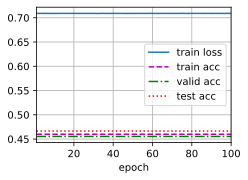

In [25]:
hidden_size = 10
out_size = 2 
num_layers = 3
dropout = 0.6

net2 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
# updater = torch.optim.SGD(net.parameters(), lr=0.01)
updater = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 100
train(net2, train_iter, valid_iter,test_iter,loss, num_epochs, updater)

In [ ]:
hidden_size = 8
out_size = 2 
num_layers = 2
dropout = 0.5
net3 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs = 100

train(net3, train_iter, valid_iter,test_iter,loss, num_epochs, updater)

In [ ]:
hidden_size = 8
out_size = 2 
num_layers = 2
dropout = 0.5
net4 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs = 100

train(net4, train_iter, valid_iter,test_iter,loss, num_epochs, updater)

In [ ]:
hidden_size = 8
out_size = 2 
num_layers = 5
dropout = 0.5
net5 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs = 100

train(net5, train_iter, valid_iter,test_iter,loss, num_epochs, updater)

In [81]:
net.eval()
y_hat = net(X_train)
y_hat = y_hat.argmax(axis=1)
cmp = y_hat.type(Y_train.dtype) == Y_train
len(y_hat),float(cmp.type(Y_train.dtype).sum())/len(y_hat)

(73838, 0.5723746580351581)

In [85]:
# net1.eval()
y_hat = net(X_test)
y_hat = y_hat.argmax(axis=1)
cmp = y_hat.type(Y_test.dtype) == Y_test
y_hat.sum()/len(y_hat),float(cmp.type(Y_test.dtype).sum())/len(y_hat)

(tensor(0.4394), 0.4574685713286591)

In [93]:
Y_test.unique()
y_hat.unique()

tensor([0, 1])

In [94]:
y_hat[:200]

tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1])

In [95]:
Y_test[:200]

tensor([ 0,  0,  0, -1,  0, -1,  1, -1, -1,  1,  1,  1,  1,  1,  0, -1,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1, -1,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  0,  0,  0,  0,  0,  1, -1,  0,  0, -1,  1, -1, -1,  1, -1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  0, -1,  1,  0,  0,  0,  0,  0,  1,  1,  1,
        -1,  1,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  1,  0,  1,  1, -1,
        -1,  1,  0,  1, -1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1, -1, -1,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1,  1, -1,  1,  1,  1,  0,
         1, -1])

In [96]:
# 突变点

count = 0
sum = 0
for i in range(1,len(y_hat) - 1):
    if y_hat[i] == 1:
        if Y_test[i] == 1 or Y_test[i] == -1:
            count += 1
        sum += 1

count / sum,count

(0.6525787965616046, 16398)

In [97]:
count = 0
sum = 0
for i in range(1,len(y_hat) - 1):
    if y_hat[i] == 0:
        if Y_test[i] == 0 or Y_test[i] == -1:
            count += 1
        sum += 1

count / sum,count

(0.6362161993575149, 20399)

In [88]:
count = 0
sum = 0
for i in range(2,len(y_hat) - 1):
    if y_hat[i] == 0 and Y_test[i - 5] == 0 :
        if Y_test[i] == 0:
            count += 1
        sum += 1

count / sum,count

(0.40505122706695257, 3400)

In [176]:
# hidden_size = 8
# out_size = 2 
# num_layers = 3
# dropout = 0.6

# torch.save(net.state_dict(),'lstm_2.params_4_3')

In [26]:
# hidden_size = 18
# out_size = 2 
# num_layers = 1
# dropout = 0

# torch.save(net.state_dict(),'lstm_2.params_3_29')

In [35]:
# hidden_size = 10
# out_size = 2 
# num_layers = 3
# dropout = 0.6
# torch.save(net.state_dict(),'lstm_2.params_3_17')

In [22]:
# net.load_state_dict(torch.load('lstm_2.params_3_17'))

<All keys matched successfully>

In [61]:
# hidden_size = 10
# out_size = 2
# num_layers = 3
# dropout = 0.5
# torch.save(net.state_dict(),'lstm_2.params_3_22')

In [36]:
net1 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

In [37]:
net1.load_state_dict(torch.load('lstm_2.params_3_17'))

<All keys matched successfully>

In [32]:
net1.eval()
net1(X_test)

tensor([[ 0.1755,  0.1709],
        [ 0.1793,  0.4922],
        [ 0.2308,  0.0877],
        ...,
        [ 0.5196, -0.1897],
        [ 0.5319, -0.2122],
        [ 0.1078,  0.2593]], grad_fn=<AddmmBackward0>)

In [47]:
hidden_size = 18
out_size = 2 
num_layers = 4
dropout = 0.5

set_seed(88)

torch.save(net.state_dict(),'lstm_2.params_3_31_3')

Random Seed: 88



In [41]:
# hidden_size = 18
# out_size = 2 
# num_layers = 2
# dropout = 0.3

# set_seed(88)
# torch.save(net.state_dict(),'lstm_2.params_3_31_2')

Random Seed: 88



In [29]:
# hidden_size = 18
# out_size = 2 
# num_layers = 1 
# dropout = 0

# torch.save(net.state_dict(),'lstm_2.params_3_31')

In [114]:
# hidden_size = 8
# out_size = 2 
# num_layers = 6
# dropout = 0.5

# set_seed(88)

# net = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

torch.save(net.state_dict(),'lstm_2.params_4_1')

# 集成尝试

In [31]:
hidden_size = 18
out_size = 2 
num_layers = 1
dropout = 0

net1 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net1.load_state_dict(torch.load('lstm_2.params_3_29'))
# torch.save(net.state_dict(),'lstm_2.params_3_29')

<All keys matched successfully>

In [32]:
hidden_size = 10
out_size = 2 
num_layers = 3
dropout = 0.6

net2 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net2.load_state_dict(torch.load('lstm_2.params_3_17'))
# torch.save(net.state_dict(),'lstm_2.params_3_17')

<All keys matched successfully>

In [33]:
hidden_size = 10
out_size = 2
num_layers = 3
dropout = 0.5

net3 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net3.load_state_dict(torch.load('lstm_2.params_3_22'))
# torch.save(net.state_dict(),'lstm_2.params_3_22')

<All keys matched successfully>

In [34]:
hidden_size = 18
out_size = 2 
num_layers = 2
dropout = 0.3
net4 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net4.load_state_dict(torch.load('lstm_2.params_3_31_2'))
# set_seed(88)
# torch.save(net.state_dict(),'lstm_2.params_3_31_2')

<All keys matched successfully>

In [35]:
hidden_size = 18
out_size = 2 
num_layers = 4
dropout = 0.5

net5 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net5.load_state_dict(torch.load('lstm_2.params_3_31_3'))

# set_seed(88)

# torch.save(net.state_dict( ),'lstm_2.params_3_31_3')

<All keys matched successfully>

In [36]:
hidden_size = 18
out_size = 2 
num_layers = 1 
dropout = 0

net6 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net6.load_state_dict(torch.load('lstm_2.params_3_31'))
# torch.save(net.state_dict(),'lstm_2.params_3_31')

<All keys matched successfully>

In [37]:
hidden_size = 8
out_size = 2 
num_layers = 6
dropout = 0.5

# set_seed(88)

net7 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net7.load_state_dict(torch.load('lstm_2.params_4_1'))
# torch.save(net.state_dict(),'lstm_2.params_4_1')

<All keys matched successfully>

In [38]:
hidden_size = 8
out_size = 2 
num_layers = 3
dropout = 0.6
net8 = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
net8.load_state_dict(torch.load('lstm_2.params_4_3'))
# torch.save(net.state_dict(),'lstm_2.params_4_3')

<All keys matched successfully>

In [39]:
net1.eval()
net2.eval()
net3.eval()
net4.eval()
net5.eval()
net6.eval()
net7.eval()
net8.eval()
net_list = [net1,net2,net3,net4,net5,net6,net7,net8]

In [40]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

y_hat = [[] for i in range(len(net_list))]
pred = [[] for i in range(len(net_list))]
for i in range(len(y_hat)):  
    y_hat[i] = net_list[i](X_test)
    pred[i] = softmax(y_hat[i])
    y_hat[i] = y_hat[i].argmax(axis=1)
    cmp = y_hat[i].type(Y_test.dtype) == Y_test
    print(float(cmp.type(Y_test.dtype).sum())/len(y_hat[i]))

0.6372458167957618
0.722518490025003
0.5291731505603833
0.5950553389400801
0.5263231514346162
0.6052838634098578
0.5630584162397496
0.5684786599758712


In [41]:
y_hat

[tensor([0, 0, 0,  ..., 1, 1, 0]),
 tensor([0, 0, 1,  ..., 1, 0, 1]),
 tensor([0, 0, 1,  ..., 0, 0, 0]),
 tensor([0, 0, 1,  ..., 1, 1, 1]),
 tensor([0, 0, 1,  ..., 1, 1, 0]),
 tensor([0, 0, 0,  ..., 0, 1, 0]),
 tensor([0, 0, 1,  ..., 1, 1, 1]),
 tensor([0, 0, 1,  ..., 1, 1, 1])]

In [44]:
y_bodong = net(X_test).argmax(axis=1)

In [96]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

## 高准确率尝试

In [124]:
f_score(pred[0],Y_test,0.6,0.6) 

(0.47188241313549467, 21499, 10145, 0.5377926421404682, 1495, 804)

In [128]:
pred[0]

tensor([[0.6631, 0.3369],
        [0.6740, 0.3260],
        [0.5596, 0.4404],
        ...,
        [0.4485, 0.5515],
        [0.4700, 0.5300],
        [0.5034, 0.4966]], grad_fn=<DivBackward0>)

In [45]:
def combine_acc(y_hat,i_list,y_bodong = 0):
    ind0_list = []
    ind1_list = []
    print('net_list：')
    print(i_list)
    y_pred = torch.zeros(len(y_hat[0]))
    for i in i_list:
        y_pred += torch.tensor(y_hat[i])
    y_0 = y_pred
#     y_p = y_0 // (len(i_list) // 2 + 1)
    y_1 = y_pred // len(i_list)
    
#     print('多数投票acc')
#     cmp = y_p.type(Y_test.dtype) == Y_test
#     ac = float(cmp.type(Y_test.dtype).sum())/len(y_p)
#     print(ac)
    
    
    count = 0
    sum = 0
    for i in range(1,len(y_0) - 1):
        if y_bodong[i] == 1:
            if y_0[i] == 0:
                if Y_test[i] == 0 or Y_test[i] == -1:
                    count += 1
                sum += 1
                ind0_list.append(i)
    print('全为0acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(2,len(y_0) - 1):
        if y_bodong[i] == 1:
            if y_0[i] == 0 and Y_test[i - 5] == 1:
                if Y_test[i] == 0 or Y_test[i] == -1:
                    count += 1
                sum += 1
    #             ind0_list.append(i)
    print('全为0，且上5min在跌acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(1,len(y_1) - 1):
        if y_bodong[i] == 1:
            if y_1[i] == 1:
                if Y_test[i] == 1 or Y_test[i] == -1:
                    count += 1
                sum += 1
                ind1_list.append(i)
    print('全为1acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(2,len(y_1) - 1):
        if y_bodong[i] == 1:
            if y_1[i] == 1 and Y_test[i - 5] == 0:
                if Y_test[i] == 1 or Y_test[i] == -1:
                    count += 1
                sum += 1
#             ind1_list.append(i)
    print('全为1，且上5min在涨acc：')
    print(count / sum,sum)
    
    return ind0_list,ind1_list
    
    

In [47]:
i_list8 = [0,1,2,3,4,5,6,7]
combine_acc(y_hat,i_list8,y_bodong)

net_list：
[0, 1, 2, 3, 4, 5, 6, 7]
全为0acc:
0.7265592730276745 2421
全为0，且上5min在跌acc:
0.6854345165238678 817
全为1acc:
0.24678111587982832 466
全为1，且上5min在涨acc：
0.20675105485232068 237


([286,
  289,
  385,
  473,
  524,
  699,
  700,
  969,
  984,
  985,
  1142,
  1143,
  1210,
  1211,
  1215,
  1286,
  1559,
  1560,
  1563,
  1897,
  1948,
  1976,
  2028,
  2034,
  2048,
  2050,
  2051,
  2122,
  2248,
  2249,
  2588,
  2593,
  2598,
  2599,
  2964,
  2969,
  2992,
  3251,
  3347,
  3349,
  3350,
  3351,
  3352,
  3354,
  3398,
  3414,
  3816,
  4558,
  4620,
  4832,
  5811,
  6146,
  6166,
  6169,
  6170,
  6171,
  6173,
  6310,
  6312,
  6540,
  7546,
  7664,
  7736,
  7892,
  7893,
  7895,
  7899,
  7961,
  8293,
  8294,
  8318,
  8403,
  8496,
  8753,
  8775,
  8776,
  8778,
  8872,
  9136,
  9141,
  9143,
  9187,
  9207,
  9209,
  9210,
  9212,
  9213,
  9214,
  9229,
  9483,
  9485,
  9489,
  9491,
  9553,
  9592,
  9634,
  9635,
  9636,
  9637,
  9638,
  9639,
  9640,
  9641,
  9644,
  9651,
  9652,
  9654,
  9661,
  9662,
  9663,
  9669,
  9670,
  9673,
  9677,
  9685,
  9687,
  9709,
  9712,
  9713,
  9769,
  9785,
  9806,
  9807,
  9862,
  9863,
  9865,
  

In [98]:
i_list1 = [4]
i_list3 = [3,4,6]
i_list5 = [0,2,3,4,6]
i_list7 = [0,1,2,3,4,5,6]
i_list8 = [0,1,2,3,4,5,6,7]
combine_acc(y_hat,i_list1)
combine_acc(y_hat,i_list3)
combine_acc(y_hat,i_list5)
combine_acc(y_hat,i_list7)
combine_acc(y_hat,i_list8)

net_list：
[4]
全为0acc:
0.6521169096955743 31272
全为0，且上5min在跌acc:
0.6659353691076193 16865
全为1acc:
0.6637987576681199 25919
全为1，且上5min在涨acc：
0.6700258749829769 14686
net_list：
[3, 4, 6]
全为0acc:
0.6626413717621306 27410
全为0，且上5min在跌acc:
0.673087002096436 15264
全为1acc:
0.6917547040070013 15997
全为1，且上5min在涨acc：
0.693795657989505 9719
net_list：
[0, 2, 3, 4, 6]
全为0acc:
0.6707486655003813 22293
全为0，且上5min在跌acc:
0.6834085778781038 12404
全为1acc:
0.696154195835985 10999
全为1，且上5min在涨acc：
0.6972088265380681 6843
net_list：
[0, 1, 2, 3, 4, 5, 6]
全为0acc:
0.6741452991452992 21528
全为0，且上5min在跌acc:
0.6866884476836727 11937
全为1acc:
0.710886075949367 5925
全为1，且上5min在涨acc：
0.7138435565559933 3554
net_list：
[0, 1, 2, 3, 4, 5, 6, 7]
全为0acc:
0.674910971266891 20499
全为0，且上5min在跌acc:
0.6875540190146932 11570
全为1acc:
0.711813526399435 5663
全为1，且上5min在涨acc：
0.7136150234741784 3408


([1,
  8,
  10,
  22,
  23,
  24,
  25,
  31,
  32,
  36,
  38,
  39,
  42,
  43,
  44,
  46,
  48,
  49,
  52,
  53,
  54,
  56,
  59,
  60,
  61,
  64,
  75,
  76,
  82,
  83,
  86,
  89,
  104,
  106,
  107,
  108,
  110,
  111,
  112,
  115,
  117,
  118,
  119,
  122,
  124,
  126,
  128,
  129,
  130,
  131,
  132,
  134,
  135,
  136,
  137,
  143,
  144,
  146,
  148,
  149,
  150,
  152,
  154,
  155,
  164,
  165,
  166,
  167,
  168,
  169,
  178,
  179,
  196,
  197,
  200,
  205,
  206,
  210,
  211,
  212,
  213,
  215,
  222,
  225,
  226,
  233,
  235,
  237,
  238,
  241,
  247,
  259,
  260,
  264,
  265,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  285,
  286,
  289,
  301,
  306,
  307,
  310,
  312,
  315,
  317,
  322,
  326,
  329,
  333,
  339,
  341,
  342,
  343,
  349,
  350,
  356,
  361,
  364,
  369,
  370,
  372,
  374,
  375,
  376,
  381,
  385,
  394,
  397,
  399,
  401,
  403,
  404,
  405,
  406,
  414,
  419,
  420,
  421,
  422,
  424,
  426

In [146]:
y_h = [[] for i in range(len(net_list))]
for i in range(len(net_list)):
    for j in range(len(pred[i])):
        if pred[i][j,0] > 0.65:
            y_h[i].append(0)
        elif pred[i][j,1] > 0.52:
            y_h[i].append(1)
        else:
            y_h[i].append(-1)
    

In [147]:
y_h[0][:500]

[0,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 0,
 1,
 0,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 0,
 1,
 1,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 1,
 1,
 -1,
 1,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 0,
 0,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 0,
 1,
 1,
 0,
 1,
 1,
 -1,
 0,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 1,
 1,
 0,
 -1,
 -1,
 -1,
 0,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 0,
 0,
 1,
 -1,
 1,
 1,
 1,
 -1,
 0,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 0,
 0,
 0,
 -1,
 1,
 0,
 -1,
 1,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 1,
 0,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 1,
 -1,
 -1,
 -1,
 -1

In [233]:
def combine_acc1(y_hat,i_list):
    ind0_list = []
    ind1_list = []
    print('net_list：')
    print(i_list)
    y_pred = torch.zeros(len(y_hat[0]))
    for i in i_list:
        y_pred += torch.tensor(y_hat[i])
    y_0 = y_pred
#     y_p = y_0 // (len(i_list) // 2 + 1)
    y_1 = y_pred // len(i_list)
    
#     print('多数投票acc')
#     cmp = y_p.type(Y_test.dtype) == Y_test
#     ac = float(cmp.type(Y_test.dtype).sum())/len(y_p)
#     print(ac)
    
    
    count = 0
    sum = 0
    for i in range(1,len(y_0) - 1):
        if y_0[i] == 0:
            if Y_test[i] == 0 or Y_test[i] == -1:
                count += 1
            sum += 1
#             ind0_list.append(i)
    print('全为0acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(2,len(y_0) - 1):
        if y_0[i] == 0 and Y_test[i - 5] == 1:
            if Y_test[i] == 0 or Y_test[i] == -1:
                count += 1
            sum += 1
            ind0_list.append(i)
    print('全为0，且上5min在跌acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(1,len(y_1) - 1):
        if y_1[i] == 1:
            if Y_test[i] == 1 or Y_test[i] == -1:
                count += 1
            sum += 1
#             ind1_list.append(i)
    print('全为1acc:')
    print(count / sum,sum)
    
    count = 0
    sum = 0
    for i in range(2,len(y_1) - 1):
        if y_1[i] == 1 and Y_test[i - 5] == 1:
            if Y_test[i] == 1 or Y_test[i] == -1:
                count += 1
            sum += 1
            ind1_list.append(i)
    print('全为1，且上5min在涨acc：')
    print(count / sum,sum)
    
    return ind0_list,ind1_list
    
    

In [48]:
ind0_list,ind1_list = combine_acc(y_hat,i_list8,y_bodong)

net_list：
[0, 1, 2, 3, 4, 5, 6, 7]
全为0acc:
0.7265592730276745 2421
全为0，且上5min在跌acc:
0.6854345165238678 817
全为1acc:
0.24678111587982832 466
全为1，且上5min在涨acc：
0.20675105485232068 237


In [49]:
len(ind0_list),len(ind1_list)

(2421, 466)

In [50]:
re = t_y.values[ind0_list,:].sum(axis = 0)
re[0]

1577.0

In [51]:
u_t = [x for x in ind0_list if (x-5) not in ind0_list]

In [52]:
len(u_t)

2017

In [53]:
# t_y.values[u_t,:].sum(axis = 0)

In [54]:
re = t_y.values[ind0_list,:].sum(axis = 0)
(re * 10 - len(u_t) * 3) / len(u_t)

array([4.818542389687655], dtype=object)

In [55]:
t_y.values[u_t,:].sum(axis = 0)

array([1397.0], dtype=object)

In [56]:
len(u_t) * 0.3

605.1

In [57]:
t_y.values[ind0_list].max() 

123.0

In [58]:
t_y.values[ind1_list,:].sum(axis = 0)

array([-312.0], dtype=object)

In [59]:
u_t = [x for x in ind1_list if (x+5) not in ind1_list]
len(u_t) 

440

In [60]:
32800 - 5081 * 3

17557

In [61]:
1756 + 7904

9660

In [132]:
3800 * 0.8 * 5

15200.0

找出下一分钟的涨跌情况，据此降低滑点

In [166]:
dt = pd.read_csv('./data//future_data.csv')
dt.drop('Unnamed: 0', axis=1, inplace=True)
dt.head()

,date,open,close,high,low,volume,open_interest
0,2010-01-04 09:01:00,3050.0,3044.0,3052.0,3037.0,24504.0,1037876.0
1,2010-01-04 09:02:00,3044.0,3043.0,3044.0,3040.0,13112.0,1039112.0
2,2010-01-04 09:03:00,3043.0,3047.0,3048.0,3042.0,14848.0,1038992.0
3,2010-01-04 09:04:00,3047.0,3045.0,3049.0,3045.0,13966.0,1039932.0
4,2010-01-04 09:05:00,3045.0,3034.0,3045.0,3033.0,13958.0,1039250.0


In [184]:
hidden_size = 8
out_size = 2 
num_layers = 3
dropout = 0.6

net = [[] for i in range(30)]
for i in range(30):
    net[i] = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)
    net[i].load_state_dict(torch.load(f'lstm_2.params_4_3_{i}'))


In [185]:
y_hat = [[] for i in range(len(net))]

for i in range(len(y_hat)):  
    y_hat[i] = net[i](X_test)
    y_hat[i] = y_hat[i].argmax(axis=1)

In [186]:
i_list30 = list(range(30))
ind0_list,ind1_list = combine_acc(y_hat,i_list30)

net_list：
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
全为0acc:
0.6695997879671349 18865
全为0，且上5min在跌acc:
0.6781423093310609 11735
全为1acc:
0.6558803535010197 14710
全为1，且上5min在涨acc：
0.6638849659776608 7789


## 74个集成

In [144]:
net_list = []
i = 0
for hidden_size in hidden_size_list:
    for num_layers in num_layers_list:
        for dropout in dropout_list:
            out_size = 2 
            net = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

            try:
                net.load_state_dict(torch.load(F'lstm_2.params_{i}'))
                net.eval()
                net_list.append(net)
                print(i)
                i+=1
                print([hidden_size,num_layers,dropout])
            except:
                continue


0
[6, 2, 0]
1
[6, 2, 0.3]
2
[6, 2, 0.5]
3
[6, 3, 0]
4
[6, 3, 0.3]
5
[6, 3, 0.5]
6
[6, 3, 0.6]
7
[6, 4, 0]
8
[6, 4, 0.3]
9
[6, 4, 0.5]
10
[6, 4, 0.6]
11
[6, 5, 0]
12
[6, 5, 0.3]
13
[6, 5, 0.5]
14
[6, 5, 0.6]
15
[6, 6, 0]
16
[6, 6, 0.3]
17
[6, 6, 0.5]
18
[6, 6, 0.6]
19
[8, 1, 0]
20
[8, 1, 0.3]
21
[8, 1, 0.5]
22
[8, 1, 0.6]
23
[8, 2, 0]
24
[8, 2, 0.3]
25
[8, 2, 0.5]
26
[8, 2, 0.6]
27
[8, 3, 0]
28
[8, 3, 0.3]
29
[8, 3, 0.5]
30
[8, 3, 0.6]
31
[8, 4, 0]
32
[8, 4, 0.3]
33
[8, 4, 0.5]
34
[8, 4, 0.6]
35
[8, 5, 0]
36
[8, 5, 0.3]
37
[8, 5, 0.5]
38
[8, 5, 0.6]
39
[8, 6, 0]
40
[8, 6, 0.3]
41
[8, 6, 0.5]
42
[8, 6, 0.6]
43
[10, 1, 0]
44
[10, 1, 0.3]
45
[10, 1, 0.5]
46
[10, 1, 0.6]
47
[10, 2, 0]
48
[10, 2, 0.3]
49
[10, 2, 0.5]
50
[10, 2, 0.6]
51
[10, 3, 0]
52
[10, 3, 0.3]
53
[10, 3, 0.5]
54
[10, 3, 0.6]
55
[10, 4, 0]
56
[10, 4, 0.3]
57
[10, 4, 0.5]
58
[10, 4, 0.6]
59
[10, 5, 0]
60
[10, 5, 0.3]
61
[10, 5, 0.5]
62
[10, 5, 0.6]
63
[10, 6, 0]
64
[10, 6, 0.3]
65
[10, 6, 0.5]
66
[10, 6, 0.6]
67
[12, 1, 0]
6

In [26]:
y_hat = [[] for i in range(len(net_list))]

for i in range(len(y_hat)):  
    y_hat[i] = net_list[i](X_test)
    y_hat[i] = y_hat[i].argmax(axis=1)
    cmp = y_hat[i].type(Y_test.dtype) == Y_test
    print(float(cmp.type(Y_test.dtype).sum())/len(y_hat[i]))

0.4503173465284213
0.439581766999458
0.4350707254384278
0.45117409473187275
0.45050967775776757
0.45307992236812195
0.4504921931005543
0.4517510884199115
0.450299861871208
0.4537967933138671
0.451366425961219
0.45010753064186176
0.45024740789956813
0.446155998111657
0.4507020089871138
0.45099924815973985
0.45064955501547393
0.4575385099575123
0.45126151801793923
0.45009004598464847
0.45009004598464847
0.45009004598464847
0.45009004598464847
0.45061458570104734
0.450002622698582
0.4564719458675013
0.4532897382546815
0.45468851083174516
0.4542164250869862
0.4521707201930306
0.4521707201930306
0.4508593709020335
0.4568391236689805
0.4527651985382827
0.45106918678859304
0.4600563005962268
0.45428636371583936
0.45395415522878674
0.4514888185617121
0.45203084293532425
0.45666427709684754
0.45351703879845434
0.4508069169303936
0.45010753064186176
0.45010753064186176
0.45010753064186176
0.45010753064186176
0.45204832759253755
0.45066703967268723
0.45395415522878674
0.4533421922263214
0.4508244

In [36]:
ind0_list,ind1_list = combine_acc(y_hat,list(range(70)))

net_list：
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
全为0acc:
0.6611702127659574 7520
全为0，且上5min在跌acc:
0.6664853101196954 5514
全为1acc:
0.6836954718858849 6029
全为1，且上5min在涨acc：
0.6834814967955344 4837
